In [13]:
%pylab inline
plt.style.use('dark_background')
from tqdm import tqdm_notebook
import numpy as np
import time
from scipy.constants import h, hbar, k as kb
from qutip import *
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


C:\Users\Ultmessia\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['identity', 'info', 'entropy', 'shape', 'squeeze']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Hamiltonmian & energy levels

Setting Hamiltonian parameters

In [15]:
def phi_coef(phi, d):
    return np.cos(phi) * (1 + (d * np.tan(phi)) ** 2) ** 0.5


Ec1 = 0.3 * 2 * np.pi
Ec2 = Ec1
Ecc = 0.0025 * 2 * np.pi
Ej1 = Ec1 * 50
Ej2 = Ec2 * 50 * 0.8
d = 0.6

""" Ec1 = 0.3 * 2*np.pi
Ec2 = Ec1
Ecc = 0.005 * 2*np.pi
Ej1 = Ec1*50
Ej2 = Ec2*50*0.8
d = 0 """

Nc = 5  # Max number of cooper pairs
Ns = Nc * 2 + 1  # Number of states of one qubit

def H(phi1, phi2):
    if phi1 != "off":
        Htr1 = 4 * (Ec1 + Ecc) * charge(Nc) ** 2 - Ej1 / 2 * phi_coef(phi1, d) * tunneling(Ns, 1)
    if phi2 != "off":
        Htr2 = 4 * (Ec2 + Ecc) * charge(Nc) ** 2 - Ej2 / 2 * phi_coef(phi2, d) * tunneling(Ns, 1)
    # Check if there is only one qubit
    if phi1 == "off": return Htr2  # tensor(identity(Ns),Htr2)
    if phi2 == "off": return Htr1  # tensor(Htr1,identity(Ns))
    H_int = -8 * Ecc * tensor(charge(Nc), identity(Ns)) * tensor(identity(Ns), charge(Nc))
    return tensor(Htr1, identity(Ns)) + tensor(identity(Ns), Htr2) + H_int

def ELevels(phi1, phi2):
    return H(phi1, phi2).eigenenergies()

def EStates(phi1, phi2):
    return H(phi1, phi2).eigenstates()

## Energy levels plots

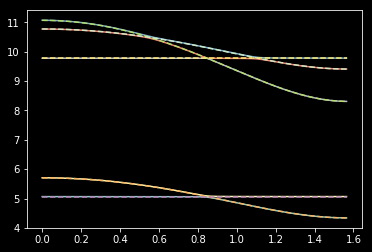

In [16]:
xL = 0  # -np.pi/2
xR = np.pi / 2
Np = 250
xData = arange(xL, xR, (xR - xL) / Np)
yData = []
for i in tqdm_notebook(range(len(xData)), desc='Energy levels calculation'):
    yData.append(ELevels(xData[i], 0) / (2 * np.pi))
yData = [yData[i] - yData[i][0] for i in range(len(xData))]
yData = [yData[i][1:6] for i in range(len(xData))]

q1levels = []
yData2 = []
for i in tqdm_notebook(range(len(xData)), desc='Product states calculation'):
    q1levels.append(ELevels(xData[i], 'off') / (2 * np.pi))
q2levels = ELevels('off', 0) / (2 * np.pi)
q1levels = [q1levels[i] - q1levels[i][0] for i in range(len(xData))]
q2levels = q2levels - q2levels[0]
yData2 = [np.append(np.append(q1levels[i][1:3], q1levels[i][0:2] + q2levels[1]), [q2levels[2]]) for i in
          range(len(xData))]

fig1 = plt.figure(1);
plot(xData, yData);
plot(xData, yData2, '--');

## AC coordinate

In [17]:
i1 = 2
i2 = 0
for i in range(0, len(xData)):
    if yData2[i][i2] < yData2[i][i1]:
        x1 = xData[i - 1]
        x2 = xData[i]
        y11 = yData2[i - 1][i1]
        y12 = yData2[i - 1][i2]
        y21 = yData2[i][i1]
        y22 = yData2[i][i2]
        a = (y12 - y11) / (y21 - y22)
        phi1 = (x1 + x2 * a) / (1 + a)
        print("|01> and |10> cross at: %f" % phi1)
        break
i1 = 3
i2 = 1
for i in range(0, len(xData)):
    if yData2[i][i2] < yData2[i][i1]:
        x1 = xData[i - 1]
        x2 = xData[i]
        y11 = yData2[i - 1][i1]
        y12 = yData2[i - 1][i2]
        y21 = yData2[i][i1]
        y22 = yData2[i][i2]
        a = (y12 - y11) / (y21 - y22)
        phi2 = (x1 + x2 * a) / (1 + a)
        print("|02> and |11> cross at: %f" % phi2)
        break

en = H(phi1,0).eigenenergies()[:6] / 2 / pi
e00 = 0
e01 = en[1] - en[0]
e10 = en[2] - en[0]
e02 = en[3] - en[0]
e11 = en[4] - en[0]
e20 = en[5] - en[0]
print("Enegry diff at AC (coupling): %f MHz" % ((e10 - e01) * 1000))



|01> and |10> cross at: 0.848062
|02> and |11> cross at: 0.555311
Enegry diff at AC (coupling): 41.841751 MHz


### State decomposition

In [18]:
# phi = 0#np.pi/2#1.14#np.pi/2
iS = 3
psi = EStates(phi1, 0)[1][iS:6]
q1States = EStates(phi1, 'off')[1]
q2States = EStates('off', 0)[1]
basisP = [[tensor(q1States[0], q2States[0]), '00'],
          [tensor(q1States[0], q2States[1]), '01'],
          [tensor(q1States[1], q2States[0]), '10'],
          [tensor(q1States[1], q2States[1]), '11'],
          [tensor(q1States[0], q2States[2]), '02'],
          [tensor(q1States[2], q2States[0]), '20']]

pr = [[0 for ps in psi] for b in basisP]
for i in range(len(basisP)):
    for j in range(len(psi)):
        prV = basisP[i][0].dag() * psi[j]
        pr[i][j] = '<%s|%i>: %s' % (basisP[i][1], j + iS, prV[0][0][0])
        # print ('|%s>: %s' %(sB[1], pr[0][0][0]))
col_width = max(len(word) for row in pr for word in row) + 2  # padding
for row in pr:
    print("".join(word.ljust(col_width) for word in row))

<00|3>: (0.00023856863594071115+0j)  <00|4>: (-1.846673188383787e-08+0j)  <00|5>: (-0.002050890490096992+0j)   
<01|3>: 0j                           <01|4>: 0j                           <01|5>: 0j                           
<10|3>: 0j                           <10|4>: 0j                           <10|5>: 0j                           
<11|3>: (-0.11122263316837552+0j)    <11|4>: (8.613547564965641e-06+0j)   <11|5>: (0.9937847260588317+0j)      
<02|3>: (-0.7027687702064741+0j)     <02|4>: (-0.7070489037018237+0j)     <02|5>: (-0.07864659608960364+0j)    
<20|3>: (0.7026606104399983+0j)      <20|4>: (-0.7071563753221312+0j)     <20|5>: (0.0786467485475758+0j)      


## Evolution ##

# Calculations

## Pulses & hamiltonian init

In [21]:
def Rect_pulse(t, duration, offset_voltage):
    return offset_voltage if 0 < t < duration else 0

def CZ_pulse(t, duration, offset_voltage, params):
    components = [params[n] * (1 - cos(2 * pi * t * (n + 1) / duration)) for n in range(len(params))]
    waveform = sum(components, axis=0) * offset_voltage /2
    return waveform
def H1_coeff(t, params):
    t_start = params['start']
    t_finish = params['duration'] + params['start']
    if t < t_start or t > t_finish:
        return 0
    else:    
        t_shift = t - t_start
        if params['gate_type'] == 'SWAP':
            return phi_coef(Rect_pulse(t_shift, params['duration'], phi1*params['amplitude']), d) - 1
        elif params['gate_type'] == 'CZ':
            return phi_coef(CZ_pulse(t_shift, params['duration'], phi2*params['amplitude'], params['CZ_params']), d) - 1

basisE = EStates(0, 0)[1][:6]
H0 = H(0, 0)
H1 = - tensor(Ej1 / 2 * tunneling(Ns, 1), identity(Ns))

def pulse_evolution(params):
    times = np.linspace(0, params['duration'] + params['start'] + params['finish'], 1000)
        
    Ht = [H0, [H1, H1_coeff]]
    options = Options(num_cpus=4, rhs_reuse=True, atol=1e-6, rtol=1e-5, store_states=True)
    return [mesolve(Ht, psi0, times, params['losses'], [], args=params, options=options) for psi0 in basisE]

## Working with matrix

In [85]:
states_index = [0, 1, 2, 4]
names = ['00', '01', '10', '02', '11', '20']
psiI = [basisE[i] for i in states_index]

def proc_matrix(result, t):
    psiF = [result[i].states[t] for i in states_index]
    proc_U = Qobj(
        [[((init).dag() * final)[0][0][0]
        #[[((init * exp(1j*enrg* times[t])).dag() * final)[0][0][0]
          for final in psiF]
         for init, enrg in zip(psiI, psiI)]
    )
    return proc_U

def proc_matrix_55(result, t):
    states_index = [0, 1, 2, 4, 5]
    psiI = [basisE[i] for i in states_index]
    psiF = [result[i].states[t] for i in states_index]
    proc_U = Qobj(
        [[((init).dag() * final)[0][0][0]
        #[[((init * exp(1j*enrg* times[t])).dag() * final)[0][0][0]
          for final in psiF]
         for init, enrg in zip(psiI, psiI)]
    )
    return proc_U

def leak_20(result, t):
    psiF = result[4].states[t]
    return abs(((basisE[5]).dag() * psiF)[0][0][0])**2

def get_phases(result):
    phases = [[], [], [], []]
    for t in range(len(times)):
        psiF = [result[i].states[t] for i in states_index]
        for j in range(4):
            phi = np.angle((psiI[j].dag()*psiF[j])[0][0][0])
            phases[j].append(phi)   
    #phases = list(map(lambda l: np.unwrap(np.array(l)) / np.pi, phases))
    phases = list(map(lambda l: np.array(l), phases))
    return phases

def get_phase_shift(result):
    phase = []
    psiF = [result[i].states[-1] for i in states_index]
    for j in range(4):
            phi = np.angle((psiI[j].dag()*psiF[j])[0][0][0])
            phase.append(phi)
    return phase[3]-phase[2]-phase[1]+phase[0]

def plot_phases(phases, ax):
    for i in range(4):
        ax.plot(times, np.unwrap(phases[i]), label=str(i))
    diff = np.unwrap(phases[3]-phases[2]-phases[1]+phases[0])
    ax.plot(times, diff, 'o', label='Diff 4-3-2+1')
    ax.legend()

## Evolution under a pulse

Calculates evolution under a pulse of a certain:
- Amplitude
- Duration
- Other params, e.g. CZ shape

In [59]:
params = {
    'duration' : 125,
    'start' : 0,
    'finish' : 0,
    'amplitude' : 0.94,
    'CZ_params': [1.09, -0.09],
    'gate_type': 'CZ',
    'losses' : []
}

#amps = linspace(0.0, 0.96, 10)
amplitudes = np.concatenate(([], linspace(0.70, 1.00, 50)))
amplitudes = [0.91, 0.8]

durations = linspace(50, 150, 21)
durations = np.concatenate(([50, 75], linspace(50, 150, 30)))
durations = [70, 150]

cz_params = linspace(0.00, 0.20, 21)
cz_params = [0.1, 0.2]
cz_params = list(zip([1]*len(cz_params), cz_params))

results = []

for dur in tqdm_notebook(durations):
    for amp in tqdm_notebook(amplitudes, leave=False):
        for cz_param in tqdm_notebook(cz_params, leave=False):
            params['duration'] = dur
            params['amplitude'] = amp
            params['CZ_params'] = cz_param
            result = pulse_evolution(params)
            times = np.linspace(0, params['duration'] + params['start'] + params['finish'], 1000)
            results.append(
                (times, dur, amp, result, cz_param)
            )

70


0.91


(70, 0.91, (1, 0.1))
(70, 0.91, (1, 0.2))
0.8


(70, 0.8, (1, 0.1))
(70, 0.8, (1, 0.2))
150


0.91


(150, 0.91, (1, 0.1))
(150, 0.91, (1, 0.2))
0.8


(150, 0.8, (1, 0.1))
(150, 0.8, (1, 0.2))



## Plots

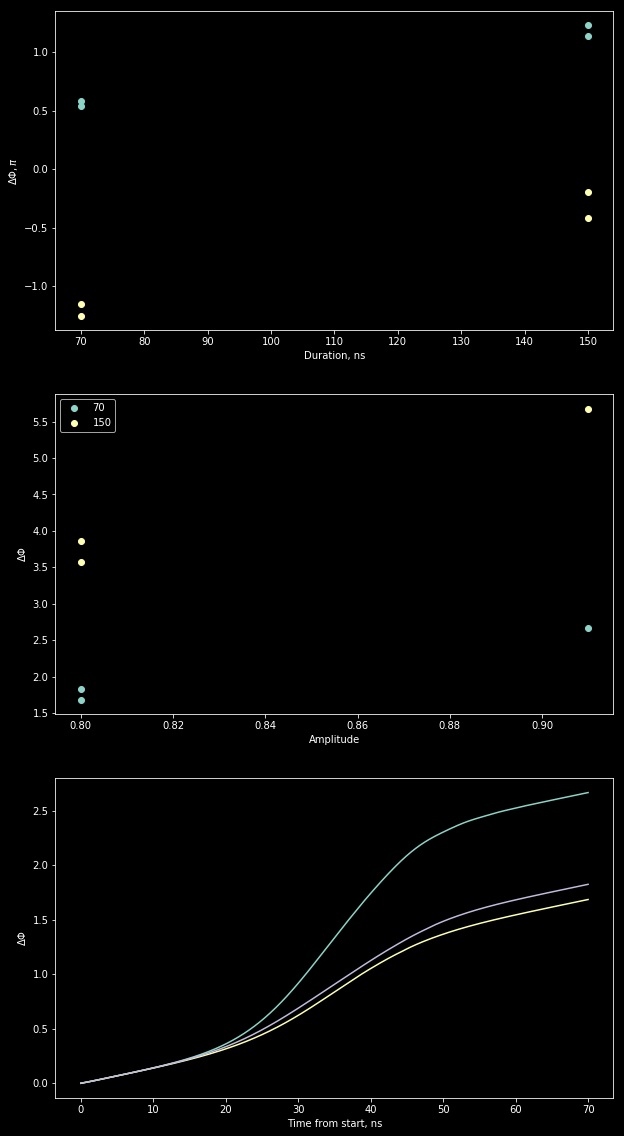

In [77]:
fig, axes = plt.subplots(3,1, figsize=(10,20))
df = pd.DataFrame(results, columns=['Times','Durs','Amps','Res', 'CZ_params'])
phase_amp = []
phase_dur = []
durs = []
amps = []
for times, dur, amp, result, cz_pars in results:
    durs.append(dur)
    amps.append(amp)
durs = np.array(durs)
amps = np.array(amps)

axes[0].set_xlabel('Duration, ns')
axes[0].set_ylabel('$\Delta \Phi, \pi$')
df['Phase'] = df.Res.apply(get_phase_shift)
for amp in np.unique(amps):
    temp = df[df.Amps == amp][:] #.plot(x='Durs', y='Phase', style='o', label=str(amp), ax=axes[0])
    durs = temp.Durs
    phase = np.unwrap(temp.Phase)/pi
    axes[0].plot(durs, phase, 'o', label=str(amp))
#axes[0].legend()

axes[1].set_xlabel('Amplitude')
axes[1].set_ylabel('$\Delta \Phi$')
for dur in np.unique(durs):
    temp = df[df.Durs == dur][1:]
    phase4 = []
    for i in tqdm_notebook(temp.index):
        phases = get_phases(temp.Res[i])
        diff = np.unwrap(phases[3]-phases[2]-phases[1]+phases[0])
        phase4.append(diff[-1])
    axes[1].plot(temp.Amps.values, phase4, 'o', label=str(dur))
axes[1].legend();

axes[2].set_xlabel('Time from start, ns')
axes[2].set_ylabel('$\Delta \Phi$')
idx = 0
temp = df[df.Durs == np.unique(durs)[idx]][1:] #.plot(x='Durs', y='Phase', style='o', label=str(amp), ax=axes[0])
for i in tqdm_notebook(temp.index[::]):
    amp = temp.Amps[i]
    phases = get_phases(temp.Res[i])
    diff = np.unwrap(phases[3]-phases[2]-phases[1]+phases[0])
    axes[2].plot(temp.Times[i], diff, label=str(amp))
#axes[2].legend()

### Fidelity vs Time

C:\Users\Ultmessia\Anaconda3\lib\site-packages\qutip\qobj.py:521: UserWarning: Multiplying superoperators with different representations
  warnings.warn(msg)


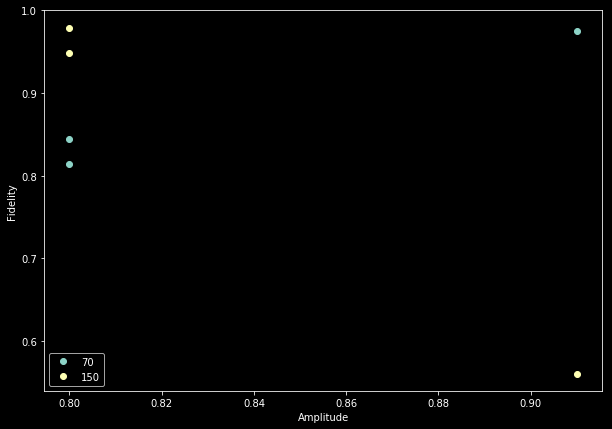

In [78]:
fig, axes = plt.subplots(figsize=(10,7))
df = pd.DataFrame(results, columns=['Times','Durs','Amps','Res','CZ_shape'])
phase_amp = []
phase_dur = []
durs = []
amps = []
for times, dur, amp, result, cz_shape in results:
    durs.append(dur)
    amps.append(amp)
durs = np.array(durs)
amps = np.array(amps)

df['Phase'] = df.Res.apply(get_phase_shift)

for dur in np.unique(durs):
    temp = df[df.Durs == dur][1:]
    fid = []
    for i in tqdm_notebook(temp.index):
        U = proc_matrix(temp.Res[i], -1).full()
        U = U / exp(1j*angle(U[0,0]))
        U[3,3] = U[3,3] / exp(1j*(angle(U[1,1]) + angle(U[2,2])))
        U[1,1] = U[1,1] / exp(1j*angle(U[1,1]))
        U[2,2] = U[2,2] / exp(1j*angle(U[2,2]))
        U = to_chi(Qobj(U, dims=[[2,2],[2,2]]))
        cz = to_chi(cphase(-pi))
        f = fidelity(U, cz) / 16
        fid.append(f)
    axes.plot(temp.Amps.values, fid, 'o', label=str(dur))
axes.set_xlabel('Amplitude')
axes.set_ylabel('Fidelity')
axes.legend();

### Fidelity vs Time

C:\Users\Ultmessia\Anaconda3\lib\site-packages\qutip\qobj.py:521: UserWarning: Multiplying superoperators with different representations
  warnings.warn(msg)


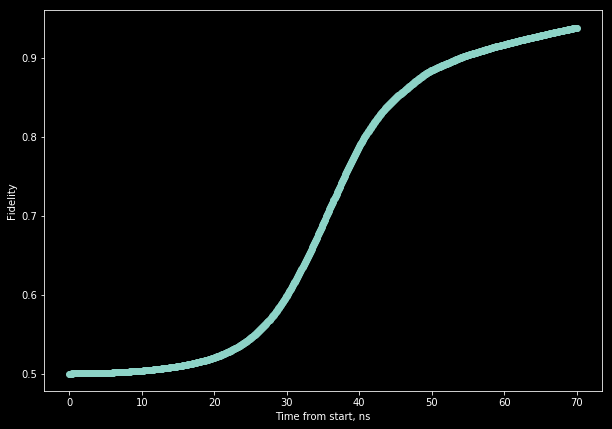

In [76]:
fig, axes = plt.subplots(figsize=(10,7))
res = results[0]
times = res[0]
fid = []
for t in tqdm_notebook(range(len(times))):
    U = proc_matrix(res[3], t).full()
    U = U / exp(1j*angle(U[0,0]))
    U[3,3] = U[3,3] / exp(1j*(angle(U[1,1]) + angle(U[2,2])))
    U[1,1] = U[1,1] / exp(1j*angle(U[1,1]))
    U[2,2] = U[2,2] / exp(1j*angle(U[2,2]))
    U = to_chi(Qobj(U, dims=[[2,2],[2,2]]))
    cz = to_chi(cphase(-pi))
    f = fidelity(U, cz) / 16
    fid.append(f)
axes.set_xlabel('Time from start, ns')
axes.set_ylabel('Fidelity')    
axes.plot(times, fid, 'o');

### Leakadge to $|02>$

Tweeking 2nd CZ_shape parameter to minimize leakadge

TODO: Fidelity for 5*5 matrices (|02> included) is not working well

C:\Users\Ultmessia\Anaconda3\lib\site-packages\qutip\qobj.py:521: UserWarning: Multiplying superoperators with different representations
  warnings.warn(msg)


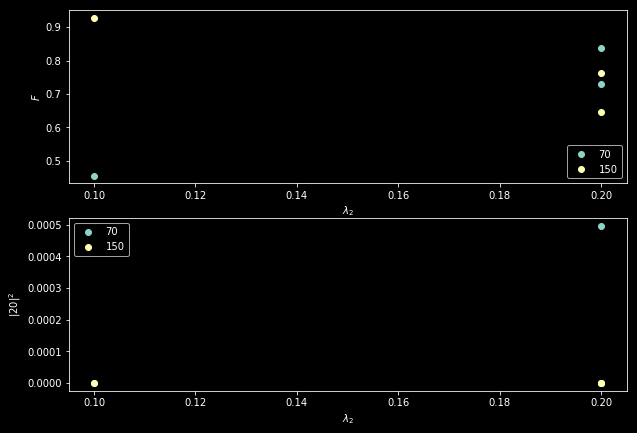

In [84]:
fig, axes = plt.subplots(2,1, figsize=(10,7))
df = pd.DataFrame(results, columns=['Times','Durs','Amps','Res', 'CZ_params'])
phase_amp = []
phase_dur = []
durs = []
amps = []
for times, dur, amp, result, cz_pars in results:
    durs.append(dur)
    amps.append(amp)
durs = np.array(durs)
amps = np.array(amps)

for dur in np.unique(durs):
    temp = df[df.Durs == dur][1:]
    fid = []
    cz_param_2 = []
    prob_20 = []
    for i in tqdm_notebook(temp.index):
        U = proc_matrix_55(temp.Res[i], -1).full()
        U = U / exp(1j*angle(U[0,0]))
        U[3,3] = U[3,3] / exp(1j*(angle(U[1,1]) + angle(U[2,2])))
        U[1,1] = U[1,1] / exp(1j*angle(U[1,1]))
        U[2,2] = U[2,2] / exp(1j*angle(U[2,2]))
        U =Qobj(U, dims=[[5],[5]])
        
        cz_55 = identity(5).full()
        cz = cphase(-pi).full()
        for j in range(4):    
            cz_55[j] = np.concatenate((cz[j], [0]))
        cz_55 = Qobj(cz_55, dims=[[5],[5]])

        f = fidelity(to_choi(U),  to_choi(cz_55)) / 5
        fid.append(f)
        cz_param_2.append(temp.CZ_params[i][1])
        prob_20.append(leak_20(temp.Res[i], -1))
    axes[0].plot(cz_param_2, fid, 'o', label=str(dur))
    axes[1].plot(cz_param_2, prob_20, 'o', label=str(dur))

axes[0].set_xlabel('$\lambda_2$')
axes[1].set_xlabel('$\lambda_2$')
axes[0].set_ylabel('$F$')
axes[1].set_ylabel('$|20|^2$')
axes[0].legend();
axes[1].legend();

## Pulse shapes

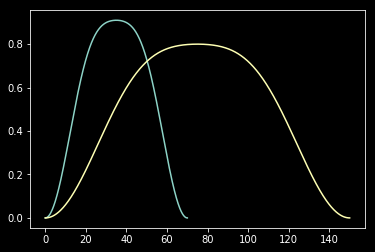

In [81]:
times, dur, amp, res, cz_shape = results[0]
pulse1 = [CZ_pulse(t , dur, amp, params['CZ_params']) for t in times]
plt.plot(times, pulse1)

times, dur, amp, res, cz_shape = results[-1]
pulse2 = [CZ_pulse(t , dur, amp, params['CZ_params']) for t in times]
plt.plot(times, pulse2);

## Trying to save (not really working with large data)

In [ ]:
with open('G:\data.joblib', 'wb') as f:
    joblib.dump(results, f)

In [204]:
with open('data.joblib', 'rb') as f:
    data_new = joblib.load(f)


[(array([ 0.        ,  0.05005005,  0.1001001 ,  0.15015015,  0.2002002 ,
          0.25025025,  0.3003003 ,  0.35035035,  0.4004004 ,  0.45045045,
          0.5005005 ,  0.55055055,  0.6006006 ,  0.65065065,  0.7007007 ,
          0.75075075,  0.8008008 ,  0.85085085,  0.9009009 ,  0.95095095,
          1.001001  ,  1.05105105,  1.1011011 ,  1.15115115,  1.2012012 ,
          1.25125125,  1.3013013 ,  1.35135135,  1.4014014 ,  1.45145145,
          1.5015015 ,  1.55155155,  1.6016016 ,  1.65165165,  1.7017017 ,
          1.75175175,  1.8018018 ,  1.85185185,  1.9019019 ,  1.95195195,
          2.002002  ,  2.05205205,  2.1021021 ,  2.15215215,  2.2022022 ,
          2.25225225,  2.3023023 ,  2.35235235,  2.4024024 ,  2.45245245,
          2.5025025 ,  2.55255255,  2.6026026 ,  2.65265265,  2.7027027 ,
          2.75275275,  2.8028028 ,  2.85285285,  2.9029029 ,  2.95295295,
          3.003003  ,  3.05305305,  3.1031031 ,  3.15315315,  3.2032032 ,
          3.25325325,  3.3033033 ,  3.

# Draft

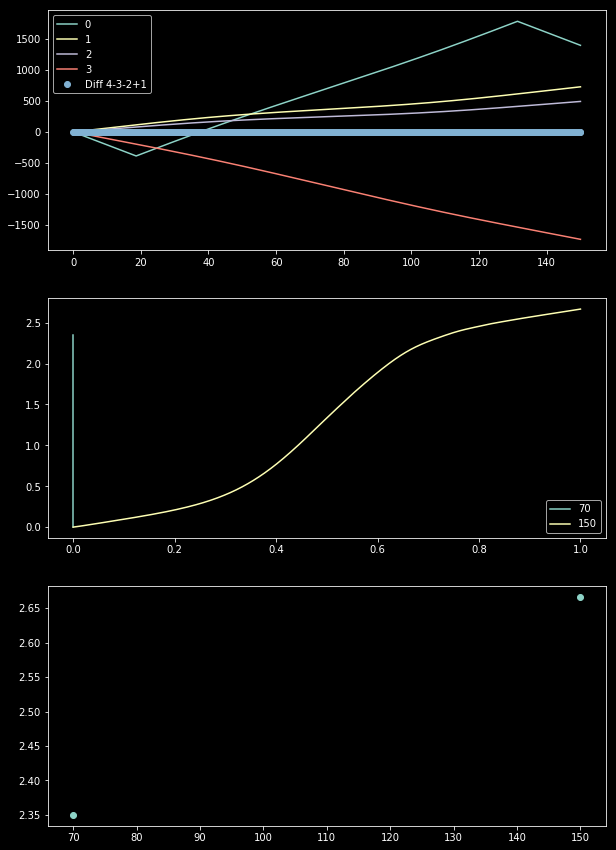

In [88]:
fig, axes = plt.subplots(3,1, figsize=(10,15))

plot_phases(get_phases(results[0][3]), axes[0])

diff_final = []
var = durations
for v in tqdm_notebook(range(len(var))):
    phases = get_phases(results[v][3])
    diff = np.unwrap(phases[3]-phases[2]-phases[1]+phases[0])
    diff_final.append(diff[-1])
    times = np.linspace(0, v + params['start'] + params['finish'], 1000)
    axes[1].plot(times, diff, label=str(var[v]))
axes[1].legend()
axes[2].plot(var, diff_final, 'o')

In [90]:
U = proc_matrix(results[-6][3], -1).full()
U = U / exp(1j*angle(U[0,0]))
U[3,3] = U[3,3] / exp(1j*(angle(U[1,1]) + angle(U[2,2])))
U[1,1] = U[1,1] / exp(1j*angle(U[1,1]))
U[2,2] = U[2,2] / exp(1j*angle(U[2,2]))


Qobj(U)

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 9.96010762e-01-2.66537252e-16j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -3.49940585e-12+8.59976681e-12j]
 [ 0.00000000e+00+0.00000000e+00j  9.95389520e-01+1.90231804e-16j
  -8.68087059e-09-3.18338658e-09j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -7.37763890e-09-3.42014825e-09j
   9.96052001e-01+1.08638408e-16j  0.00000000e+00+0.00000000e+00j]
 [ 8.55131629e-11-2.23013489e-10j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -1.14033568e-01+9.89705421e-01j]]

Amp:
[[9.95696605e-01 0.00000000e+00 0.00000000e+00 2.78580813e-12]
 [0.00000000e+00 9.95423702e-01 3.19956478e-08 0.00000000e+00]
 [0.00000000e+00 2.97594046e-08 9.96041411e-01 0.00000000e+00]
 [1.17136340e-10 0.00000000e+00 0.00000000e+00 9.95985114e-01]]
Phase:
[[ 0.05226811  0.          0.          1.        ]
 [ 0.          0.89052712  0.84879208  0.        ]
 [ 0.          0.83176169 -0.20943379  0.        ]
 [-0.00933067  0.          0.         -0.52242536]]
Phase shift: -1.182589089384026
Purities:
[0.9914117289667782, 0.990868346546013, 0.9920984917608568, 0.9919863468911541]


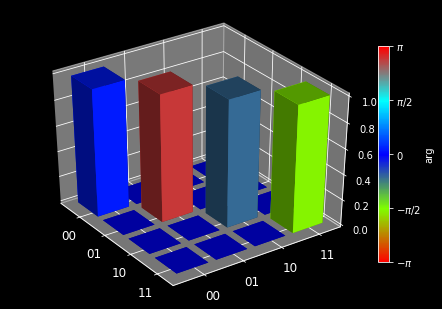

In [101]:
result = results[1][3]

time = -1

states_index = [0, 1, 2, 4]
psiI = [basisE[i] for i in states_index]
psiF = [result[i].states[time] for i in states_index]

proc_U = Qobj(
    [[(init.dag() * final)[0][0][0]
      for final in psiF]
     for init in psiI]
)
    
pur = [
    sum([np.abs((init.dag() * final)[0][0][0])**2
      for init in psiI])
     for final in psiF]
fig2, ax2 = matrix_histogram_complex(proc_U, [b[1] for b in basisP[:4]], [b[1] for b in basisP[:4]])
print('Amp:', np.abs(proc_U.full()), sep='\n')
print('Phase:', np.angle(proc_U.full()) / np.pi, sep='\n')
print('Phase shift:', (np.angle(proc_U[3,3]) - np.angle(proc_U[2,2]) - np.angle(proc_U[1,1] + np.angle(proc_U[0,0])) )/ np.pi)
print('Purities:', pur, sep='\n')
#proc_U

## Evolution of product states (Old)

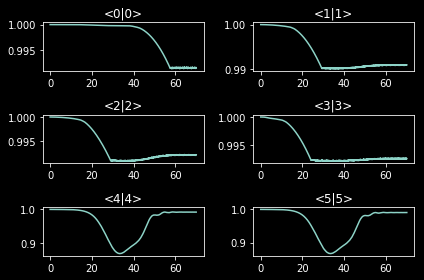

' picDir = \'pics/\'\nconf_name = \'config2\'\nfig1.savefig(picDir + conf_name + ".png")\ninfo = open(picDir + conf_name + \'.txt\' ,\'w\') \ninfo.write(\'Ec1 = \' +  str(Ec1/(2*np.pi))+\' GHz\n\')\ninfo.write(\'Ec2 = \' +  str(Ec2/(2*np.pi))+\' GHz\n\')\ninfo.write(\'Ej1 = \' +  str(Ej1/(2*np.pi))+\' GHz\n\')\ninfo.write(\'Ej2 = \' +  str(Ej2/(2*np.pi))+\' GHz\n\')\ninfo.write(\'Ecc = \' +  str(Ecc/(2*np.pi))+\' GHz\n\')\ninfo.write(\'d = \' +  str(d)+\'\n\')\ninfo.close() '

In [100]:
## Evolution of product states
Up = [[[0 for t in times] for i in basisP] for j in basisP]
# In rotating frame (somewhat)
'''for i in range(len(times)):
    for j in range(len(basisP)):
        for k in range(len(basisP)):
            psiI = result0[j].states[i]
            psiF = result[k].states[i]
            Up[j][k][i] = (psiI.dag()*psiF)[0][0][0] '''

# No rotating frame
for i in range(len(times)):
    for j in range(len(basisE)):
        for k in range(len(basisE)):
            psiI = basisE[j]
            psiF = result[k].states[i]
            Up[j][k][i] = np.abs((psiI.dag() * psiF)[0][0][0]) ** 2

fig3 = plt.figure(3)
for i in range(len(basisE)):
    plt.subplot(3, 2, i + 1)
    plt.title('<%s|%s>' % (i, i))
    plot(times, Up[i][i])

# plot(times, result[2].expect[1])
# plt.legend(["Product state", "Energy state"])
# fig1 = plt.figure(2)
# yData2 = [np.angle((psiI[i].dag()*psiF[i])[0][0][0]) for i in range(len(psiF))]
# plot(times, yData2)
# plot(times,[PulseFromArray(t, T_arr, Phi_arr) for t in times])
# plot(xData1,yData1)
plt.tight_layout()
plt.show()

# print(yData[Np//2])

''' picDir = 'pics/'
conf_name = 'config2'
fig1.savefig(picDir + conf_name + ".png")
info = open(picDir + conf_name + '.txt' ,'w') 
info.write('Ec1 = ' +  str(Ec1/(2*np.pi))+' GHz\n')
info.write('Ec2 = ' +  str(Ec2/(2*np.pi))+' GHz\n')
info.write('Ej1 = ' +  str(Ej1/(2*np.pi))+' GHz\n')
info.write('Ej2 = ' +  str(Ej2/(2*np.pi))+' GHz\n')
info.write('Ecc = ' +  str(Ecc/(2*np.pi))+' GHz\n')
info.write('d = ' +  str(d)+'\n')
info.close() '''